# CNN with reduced features from dataset and generated features

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../daatsets/combined_reduced.csv')

In [3]:
X1 = np.load('../datasets/final_X.npy')

In [4]:
# Convert the DataFrame to a NumPy array
df_array = df.to_numpy()

# Stack the DataFrame and the NumPy array horizontally
X_final = np.hstack((df_array, X1))

In [5]:
target = pd.read_csv('../datasets/kag_red.csv')

In [6]:
from sklearn.model_selection import train_test_split

y = target['subreddit']  # Target

In [7]:
# merge X_final and y to single dataframe
df_final = pd.DataFrame(X_final)
df_final['subreddit'] = y

In [10]:
import pandas as pd
import numpy as np

# Get indexes of rows where subreddit is 'depression'
depression_rows = df_final[df_final['subreddit'] == 'depression'].index

# Calculate the number of rows to keep and remove for 'depression' subreddit
total_depression_rows = len(depression_rows)
rows_to_keep = int(total_depression_rows * 0.45)  # 45% of the rows to keep

# Randomly select 45% of the rows to keep
rows_to_keep_indexes = np.random.choice(depression_rows, size=rows_to_keep, replace=False)

# Get the indexes of rows to remove
rows_to_remove_indexes = depression_rows.difference(rows_to_keep_indexes)

# Remove 55% of rows with subreddit 'depression' 
df_final.drop(rows_to_remove_indexes, inplace=True)

# Now df contains 45% of the original 'depression' rows randomly selected and all other rows intact


In [11]:
# Get indexes of rows where subreddit is 'suicidewatch'
s_rows = df_final[df_final['subreddit'] == 'suicidewatch'].index

# Calculate the number of rows to keep and remove for 'suicidewatch' subreddit
total_s_rows = len(s_rows)
rows_to_keep = int(total_s_rows * 0.85)  # 85% of the rows to keep

# Randomly select 85% of the rows to keep
rows_to_keep_indexes = np.random.choice(s_rows, size=rows_to_keep, replace=False)

# Get the indexes of rows to remove
rows_to_remove_indexes = s_rows.difference(rows_to_keep_indexes)

# Remove 15% of rows with subreddit 'suicidewatch'
df_final.drop(rows_to_remove_indexes, inplace=True)

In [12]:
# print types of X_final and y
print(type(X_final))
print(type(y))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [13]:

X_final_d = df_final.drop('subreddit', axis=1)
y_final_d = df_final['subreddit']


In [14]:
# convert X_final_d and y_final_d to numpy arrays
X_final_d = X_final_d.to_numpy()

In [15]:
# print the shape of X_final and y
print(X_final_d.shape)
print(y_final_d.shape)

(300041, 1141)
(300041,)


In [16]:
# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_final_d, y_final_d, test_size=0.2, random_state=42)


In [17]:

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 

# Step 1: Encode the categorical target variable (y_train) using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.values.reshape(-1, 1))

# Step 2: Flatten the encoded labels
y_train_encoded = y_train_encoded.argmax(axis=1)
y_val_encoded = y_val_encoded.argmax(axis=1)
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).argmax(axis=1)
y_train_encoded = to_categorical(y_train_encoded) 
y_val_encoded = to_categorical(y_val_encoded) 


## Compiling and training the model

In [19]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'CNN_combined.ipynb'

In [20]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import accuracy_score
import numpy as np

wandb.init(project='Reddit_mental_CNN_aayush')

# Your data: X_train, X_val, X_test, y_train_encoded, y_val_encoded, y_test_encoded

# Manual specification of parameters for the first run
params = {
    'filters': 16, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 200, 'act': 'tanh'
}

wandb: Currently logged in as: aayushach16 (boys69). Use `wandb login --relogin` to force relogin


In [21]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 3 or epoch == 6:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_relu_{}.hd5".format(epoch))

In [22]:
import tensorflow as tf

model = Sequential()
model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation=params['act'],
                 input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=params['pool_size']))
model.add(Flatten())
model.add(Dense(params['dense_units'], activation=params['act']))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

saver = CustomSaver()

history = model.fit(X_train_reshaped, y_train_encoded, epochs=15, batch_size=16,
                    validation_data=(X_val_reshaped, y_val_encoded),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                               WandbCallback(), saver])

X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test_encoded, y_pred_classes)

wandb.log({'test_accuracy': accuracy})
wandb.log({'validation_loss': history.history['val_loss'][len(history.history['val_loss']) - 1], 'epoch': len(history.history['val_loss'])})





wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/15
11249/11252 [============================>.] - ETA: 0s - loss: 1.0251 - accuracy: 0.6597

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best)... Done. 0.1s


11252/11252 [==============================] - 162s 14ms/step - loss: 1.0250 - accuracy: 0.6597 - val_loss: 0.8726 - val_accuracy: 0.7050
Epoch 2/15
11250/11252 [============================>.] - ETA: 0s - loss: 0.8283 - accuracy: 0.7195

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best)... Done. 0.1s


11252/11252 [==============================] - 147s 13ms/step - loss: 0.8283 - accuracy: 0.7195 - val_loss: 0.8288 - val_accuracy: 0.7185
Epoch 3/15
11250/11252 [============================>.] - ETA: 0s - loss: 0.8011 - accuracy: 0.7278

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best)... Done. 0.1s


11252/11252 [==============================] - 160s 14ms/step - loss: 0.8011 - accuracy: 0.7278 - val_loss: 0.8276 - val_accuracy: 0.7149
Epoch 4/15
11249/11252 [============================>.] - ETA: 0s - loss: 0.7853 - accuracy: 0.7318

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: model_relu_3.hd5/assets


INFO:tensorflow:Assets written to: model_relu_3.hd5/assets


11252/11252 [==============================] - 150s 13ms/step - loss: 0.7853 - accuracy: 0.7318 - val_loss: 0.8132 - val_accuracy: 0.7201
Epoch 5/15
11252/11252 [==============================] - 144s 13ms/step - loss: 0.7734 - accuracy: 0.7353 - val_loss: 0.8138 - val_accuracy: 0.7188
Epoch 6/15
11250/11252 [============================>.] - ETA: 0s - loss: 0.7627 - accuracy: 0.7378

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best)... Done. 0.1s


11252/11252 [==============================] - 123s 11ms/step - loss: 0.7626 - accuracy: 0.7378 - val_loss: 0.8006 - val_accuracy: 0.7255
Epoch 7/15
11247/11252 [============================>.] - ETA: 0s - loss: 0.7533 - accuracy: 0.7404

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best)... Done. 0.1s


INFO:tensorflow:Assets written to: model_relu_6.hd5/assets


INFO:tensorflow:Assets written to: model_relu_6.hd5/assets


11252/11252 [==============================] - 128s 11ms/step - loss: 0.7532 - accuracy: 0.7404 - val_loss: 0.7981 - val_accuracy: 0.7257
Epoch 8/15
11252/11252 [==============================] - ETA: 0s - loss: 0.7440 - accuracy: 0.7427

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best)... Done. 0.1s


11252/11252 [==============================] - 114s 10ms/step - loss: 0.7440 - accuracy: 0.7427 - val_loss: 0.7928 - val_accuracy: 0.7268
Epoch 9/15
11249/11252 [============================>.] - ETA: 0s - loss: 0.7356 - accuracy: 0.7441

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best)... Done. 0.1s


11252/11252 [==============================] - 130s 12ms/step - loss: 0.7357 - accuracy: 0.7441 - val_loss: 0.7888 - val_accuracy: 0.7287
Epoch 10/15
11251/11252 [============================>.] - ETA: 0s - loss: 0.7273 - accuracy: 0.7465

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best)... Done. 0.1s


11252/11252 [==============================] - 109s 10ms/step - loss: 0.7273 - accuracy: 0.7466 - val_loss: 0.7878 - val_accuracy: 0.7289
Epoch 11/15
11251/11252 [============================>.] - ETA: 0s - loss: 0.7199 - accuracy: 0.7488

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best)... Done. 0.1s


11252/11252 [==============================] - 119s 11ms/step - loss: 0.7199 - accuracy: 0.7488 - val_loss: 0.7799 - val_accuracy: 0.7285
Epoch 12/15
11249/11252 [============================>.] - ETA: 0s - loss: 0.7119 - accuracy: 0.7506

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best)... Done. 0.1s


11252/11252 [==============================] - 112s 10ms/step - loss: 0.7119 - accuracy: 0.7506 - val_loss: 0.7785 - val_accuracy: 0.7314
Epoch 13/15
11251/11252 [============================>.] - ETA: 0s - loss: 0.7036 - accuracy: 0.7536

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best)... Done. 0.1s


11252/11252 [==============================] - 117s 10ms/step - loss: 0.7036 - accuracy: 0.7536 - val_loss: 0.7784 - val_accuracy: 0.7322
Epoch 14/15
11251/11252 [============================>.] - ETA: 0s - loss: 0.6954 - accuracy: 0.7559

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_220738-93sizakz/files/model-best)... Done. 0.1s


11252/11252 [==============================] - 110s 10ms/step - loss: 0.6955 - accuracy: 0.7559 - val_loss: 0.7703 - val_accuracy: 0.7347
Epoch 15/15
1876/1876 [==============================] - 4s 2ms/step


## Results

In [30]:

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_classes))

Accuracy: 0.731756903131197
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75      1494
           1       0.82      0.91      0.86      9186
           2       0.82      0.72      0.76      1182
           3       0.83      0.80      0.82     11542
           4       0.87      0.71      0.78      1780
           5       0.70      0.69      0.70      4883
           6       0.60      0.52      0.56     10534
           7       0.71      0.67      0.69      4790
           8       0.75      0.69      0.72      1718
           9       0.64      0.68      0.66      1645
          10       0.67      0.77      0.72     11255

    accuracy                           0.73     60009
   macro avg       0.74      0.72      0.73     60009
weighted avg       0.73      0.73      0.73     60009



In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute confusion matrix in percentage of total test samples
cm = confusion_matrix(y_test_encoded, y_pred_classes)


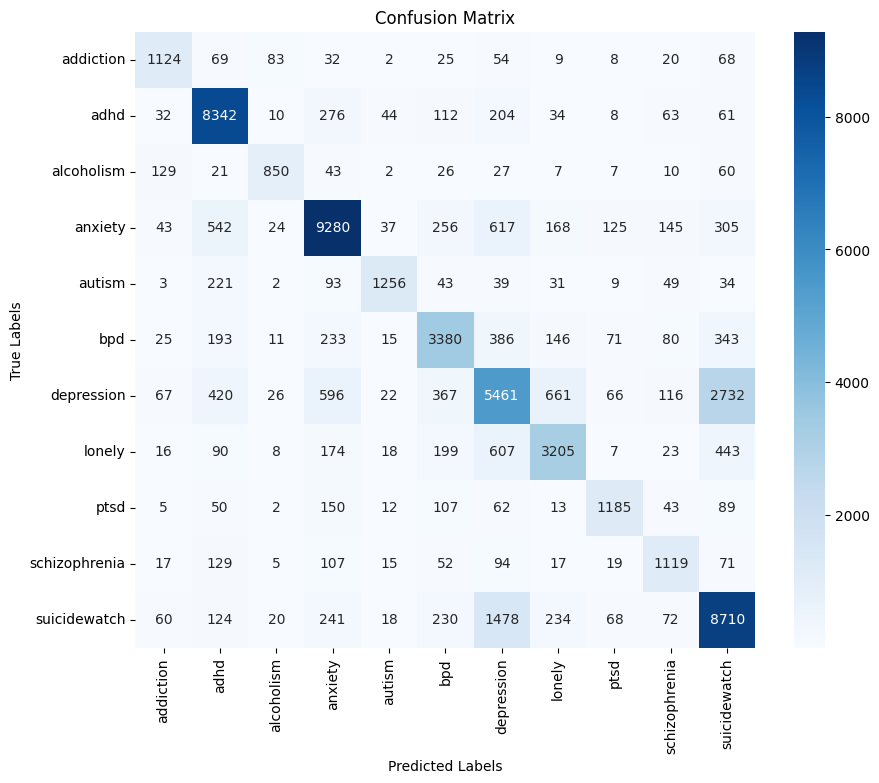

In [32]:


# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [33]:
# print count of categories in y_test
print(y_test.value_counts())

subreddit
anxiety          11542
suicidewatch     11255
depression       10534
adhd              9186
bpd               4883
lonely            4790
autism            1780
ptsd              1718
schizophrenia     1645
addiction         1494
alcoholism        1182
Name: count, dtype: int64


In [ ]:
del model